# Descriptive title that follows notebook filename

**Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only**

### General advice (delete this cell before submitting for review)

- When choosing a location for your analysis, **select an area that has data on both the `NCI` and `DEA Sandbox`** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products). 
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
- When writing in Markdown cells, start each sentence is on a **new line**.
This makes it easy to see changes through git commits.
- Use Australian English in markdown cells and code comments.
- Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
- In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case, seperate words with spaces, and where possible re-use existing tags.
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


### Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

### Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above, and a run-down of the tools/methods being demonstrated below.


### Technical details
* **Products used:** `product_name`, `product_name`, `product_name`
* **Analyses used:** NDWI water index, geomedian compositing, pixel drill
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook

## Getting started
Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_masking import mask

In [2]:
poly = """{
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [
            136.91986083984375,
            -33.66549665763364
          ],
          [
            136.86492919921872,
            -33.71577279930021
          ],
          [
            136.84432983398438,
            -33.75403149821638
          ],
          [
            136.84398651123047,
            -33.798835278253975
          ],
          [
            136.86458587646484,
            -33.79312909288506
          ],
          [
            136.96208953857422,
            -33.745467600106174
          ],
          [
            136.96964263916016,
            -33.738615865848736
          ],
          [
            136.9552230834961,
            -33.73490428127589
          ],
          [
            136.98612213134766,
            -33.693780606387506
          ],
          [
            136.97650909423828,
            -33.667211101197545
          ],
          [
            136.91986083984375,
            -33.66549665763364
          ]
        ]
      }
    }"""

In [3]:
dc = datacube.Datacube(app="Tidal_powerplant")

<xarray.DataArray 'relative' (y: 698, x: 764)>
array([[9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y        (y) float64 -3.68e+06 -3.68e+06 -3.68e+06 ... -3.698e+06 -3.698e+06
  * x        (x) float64 4.434e+05 4.434e+05 4.434e+05 ... 4.624e+05 4.625e+05
Attributes:
    units:    0.1
    nodata:   -6666
    crs:      EPSG:3577


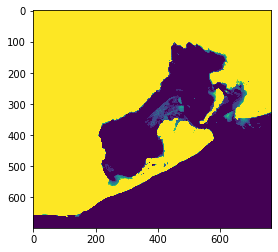

In [16]:
y = -33.683333
x = 136.916667

query = {'x': (x - .1, x + .1),
         'y': (y - .12, y + 0.03),         
         'crs': 'EPSG:4326'}

# Import ITEM v2.0 relative layer 
item_data = dc.load(product = 'item_v2', **query)

# Squeeze out the unnecessary temporal dimension:
item_data = item_data.squeeze(dim = 'time', drop = True)
print(item_data.relative)

data = np.clip(item_data.relative.data, 0, 9)
plt.imshow(data)

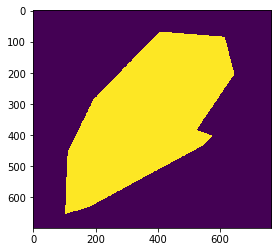

In [6]:
msk = mask(item_data.relative, poly)
plt.imshow(msk)

(698, 764)
(698, 764)
(533272,)
(533272,)


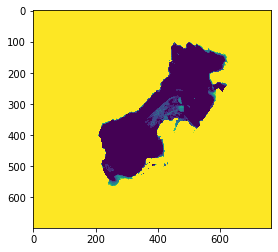

In [17]:
print(item_data.relative.data.shape)
print(msk.shape)

data = data.flatten()
print(data.shape)
data[~msk.flatten()] = 9
print(data.shape)


plt.imshow(data.reshape(msk.shape))

### Connect to the datacube
Give your datacube app a unique name that is consistent with the purpose of the notebook.

In [2]:
dc = datacube.Datacube(app="DEA_notebooks_template")

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:
* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [3]:
param_name_1 = "example_value"
param_name_2 = "example_value"

## Heading 1
Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [4]:
# Use code comments for low-level documentation of code
a = 1

### Subheading 1
Use subheadings to break up steps within a single section.

In [5]:
# Use code comments for low-level documentation of code
b = 2

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [6]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [7]:
print(datacube.__version__)

1.7+43.gc873f3ea


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)